# Capstone Project: Using NLP to Summarize Contracts

## Problem Statement 
Contracts can be long, dense and inaccessible, and a quick way to summarize the topics can give at least a good bird's eye view for legal stakeholders.

Can we use NLP models like Transformers or LDA (TBC) to summarize the topics of a contract's content? To measure success, we will use perplexity and coherence, which are topic modelling classification metrics.

Perplexity captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set - how well does the model represent or reproduce the statistics of the held-out data?

Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. 

* Initial Code adapted from Oguejio for Chibueze's NLP modelling article:
https://towardsdatascience.com/nlp-for-topic-modeling-summarization-of-legal-documents-8c89393b1534
* Topic Modelling metrics explanation:
https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

## Initial Imports

In [1]:
import re #we need regex because we're going to parse through textual data

You have to run `pip install PyPDF` in your command line terminal.

In [104]:
#importing textual pandas, numpy, as well as PyPDF, 
# which is a Pure-Python library built as a PDF toolkit.
import string 
import PyPDF2 as p2
import numpy as np 
import pickle
import pandas as pd 

#Imports For Visuals
import matplotlib.pyplot as plt
#making our square treemap plot larger
from matplotlib import rcParams
rcParams['figure.figsize'] = 16, 9
import seaborn as sns

%matplotlib inline

#plotly, squarify and cufflinks interactive chart imports

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.express as px #another related library of plotly that makes it easy to draw multiple plots
import squarify

#we have to make sure this code is run for Jupyter Notebooks otherwise the plots may not happen offline:
init_notebook_mode(connected=True)
cf.go_offline()

In [3]:
# Gensim - a Natural Language Processing package that does ‘Topic Modeling for Humans'
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

In [4]:
# NLTK Stop words - imported and also extended
import nltk  # for text manipulation 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 
                   'use', 'not', 'would', 'say', 'could', '_', 
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 
                   'try', 'many', 'some', 'nice', 'thank', 'think', 
                   'see', 'rather', 'easy', 'easily', 
                   'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 
                   'right', 'line', 'even', 'also', 'may', 'take', 'come'])

in command line terminal, type `python -m spacy download en_core_web_md`

In [5]:
import re    # for regular expressions 
import spacy # another text processing library like nltk
import en_core_web_md 

#en core web md is from spacy. it's an English multi-task CNN trained on OntoNotes, 
#with GloVe vectors trained on Common Crawl. 
#Assigns word vectors, POS tags, dependency parse and named entities.
#https://spacy.io/models/en#en_core_web_md

nlp = en_core_web_md.load()

## Reading in PDF Data then Converting to Pandas

In [111]:
#have to pip install pdfminer3, these imports and this loop will convert 
#whatever pdf is passed in the filepath after "open" into text.
#https://stackoverflow.com/questions/56494070/how-to-use-pdfminer-six-with-python-3

In [56]:
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter
import io

resource_manager = PDFResourceManager()
fake_file_handle = io.StringIO()
converter = TextConverter(resource_manager, fake_file_handle, laparams=LAParams())
page_interpreter = PDFPageInterpreter(resource_manager, converter)

with open('../data/contract_sample.pdf', 'rb') as fh:

    for page in PDFPage.get_pages(fh,
                                  caching=True,
                                  check_extractable=True):
        page_interpreter.process_page(page)

    text = fake_file_handle.getvalue()

# close open handles
converter.close()
fake_file_handle.close()

print(text)

TRADEMARK AND DOMAIN NAME AGREEMENT 

This agreement (the “Agreement”) is by and between ____________________________ 

 
 
(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  
201[__] (the “Effective Date”). 
 

WHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the 

“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); 

 
WHEREAS, Party is desirous of Eclipse to initiate a project or working group with a 

name based on the Trademark (the “Project Initiation”); 

 
WHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s 

rights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain 
continuing usage rights of the Trademarks; 

 
WHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to 
have any related Domain Names initially redirect to a URL designated by Eclipse and that the 
Domain Names are 

In [60]:
type(text)

#we just created one gigantic string

str

In [65]:
#read the text as a list

text_list = text.split("delimiter")

In [66]:
text_list

['TRADEMARK AND DOMAIN NAME AGREEMENT \n\nThis agreement (the “Agreement”) is by and between ____________________________ \n\n \n \n(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____],  \n201[__] (the “Effective Date”). \n \n\nWHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the \n\n“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); \n\n \nWHEREAS, Party is desirous of Eclipse to initiate a project or working group with a \n\nname based on the Trademark (the “Project Initiation”); \n\n \nWHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s \n\nrights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain \ncontinuing usage rights of the Trademarks; \n\n \nWHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to \nhave any related Domain Names initially redirect to a URL designated by Eclipse an

The list is full of unwanted textual elements like line breaks, quotation marks, and underscores. All this will be removed in further down.

In [110]:
#let's convert this into a DataFrame for now.
text_frame = pd.DataFrame(text_list, columns=["contract_text"])

In [78]:
#we're gonna have to read a lot of words in columns, so let's expand the column width:
pd.set_option("display.max_colwidth", 1000)


In [84]:
df = text_frame

df

,contract_text
0,"TRADEMARK AND DOMAIN NAME AGREEMENT \n\nThis agreement (the “Agreement”) is by and between ____________________________ \n\n \n \n(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____], \n201[__] (the “Effective Date”). \n \n\nWHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the \n\n“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); \n\n \nWHEREAS, Party is desirous of Eclipse to initiate a project or working group with a \n\nname based on the Trademark (the “Project Initiation”); \n\n \nWHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s \n\nrights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain \ncontinuing usage rights of the Trademarks; \n\n \nWHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to \nhave any related Domain Names initially redirect to a URL designated by Eclipse ..."


# Cleaning and Pre-Processing

For our columns `title` and `selftext`, we will need to convert the text into a "bag of words" i.e. unique words in a text represented by a number. To facilitate this we must first pre-process by 

    1. getting rid of punctuation and non-words using RegEx, 
    2. lowercasing everything, 
    3. removing "stop words" i.e. conjunctive/article type words with no substantial meaning for content, 
    4. lemmatizing e.g. contracting words like run/ran/runs into run.

In [81]:
#this requires new imports for our custom function:

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

import regex as re

In [82]:
#instantiate the lemmatizer

lemmatizer = WordNetLemmatizer()

In [83]:
#adapted from GA tutorial:

def word_cleaner(mess):
    
    #removing non-letters including spaces
    just_letters = re.sub("[^a-zA-Z]", " ", mess)
    
    #lower-casing
    small_caps = just_letters.lower().split()
    
    #assign stopwords into a set and then removing those from target text
    stops = set(stopwords.words('english'))
    important_words = [string for string in small_caps if not string in stops]
    
    #lemmatize the important words 
    lem_words_only = [lemmatizer.lemmatize(word) for word in important_words]

    #get rid of all the quotation marks
    clean_stage1=[i.replace('\xe2\x80\x9c','') for i in lem_words_only]
    clean2=[i.replace('\xe2\x80\x9d','') for i in clean_stage1 ]
    clean3=[i.replace('\xe2\x80\x99s','') for i in clean2 ]
    
    #rejoin all the words into a string separated by a space
    return(" ".join(clean3))

In [87]:
#using .apply to run the function across the whole selftext column

df["contract_text"].apply(word_cleaner)

0    trademark domain name agreement agreement agreement party eclipse foundation inc eclipse effective effective date whereas party owner certain trademark identified exhibit trademark certain domain name identified exhibit domain name whereas party desirous eclipse initiate project working group name based trademark project initiation whereas accommodate project initiation party desire transfer party right title interest trademark eclipse thereafter certain continuing usage right trademark whereas accommodate project initiation party may mutually agree related domain name initially redirect url designated eclipse domain name subsequently transferred eclipse consideration foregoing good valuable consideration receipt sufficiency hereby acknowledged party agree follows trademark assignment party irrevocably assigns grant transfer eclipse party right title interest trademark including common law right trademark registration application along goodwill business symbolized use trademark ri

In [89]:
#creating a new, cleaned column to put into our dataframe

df['cleaned_text']=df['contract_text'].apply(word_cleaner)

In [92]:
#comparing our cleaned vs messy columns to see what the change looks like
df

,contract_text,cleaned_text
0,"TRADEMARK AND DOMAIN NAME AGREEMENT \n\nThis agreement (the “Agreement”) is by and between ____________________________ \n\n \n \n(“Party”) and Eclipse Foundation, Inc. (“Eclipse”) and is effective as of [______] [_____], \n201[__] (the “Effective Date”). \n \n\nWHEREAS, Party is the owner of certain trademarks identified in Exhibit A (the \n\n“Trademarks”) and of certain domain names identified in Exhibit A (the “Domain Names”); \n\n \nWHEREAS, Party is desirous of Eclipse to initiate a project or working group with a \n\nname based on the Trademark (the “Project Initiation”); \n\n \nWHEREAS, to accommodate the Project Initiation, Party desires to transfer all of Party’s \n\nrights, title and interest in and to the Trademarks to Eclipse and to thereafter have certain \ncontinuing usage rights of the Trademarks; \n\n \nWHEREAS, to accommodate the Project Initiation, the Parties may mutually agree to \nhave any related Domain Names initially redirect to a URL designated by Eclipse ...",trademark domain name agreement agreement agreement party eclipse foundation inc eclipse effective effective date whereas party owner certain trademark identified exhibit trademark certain domain name identified exhibit domain name whereas party desirous eclipse initiate project working group name based trademark project initiation whereas accommodate project initiation party desire transfer party right title interest trademark eclipse thereafter certain continuing usage right trademark whereas accommodate project initiation party may mutually agree related domain name initially redirect url designated eclipse domain name subsequently transferred eclipse consideration foregoing good valuable consideration receipt sufficiency hereby acknowledged party agree follows trademark assignment party irrevocably assigns grant transfer eclipse party right title interest trademark including common law right trademark registration application along goodwill business symbolized use trademark rig...


In [93]:
#backing up this dataframe in case things go horribly wrong in Word Vectorization

df.to_csv("../data/df.csv", index=False)

## Initial Text EDA and Visualization

In [94]:
#import the vectorizer,

from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp

#intialize it and assign as vectorizer 
vectorizer = CountVectorizer(ngram_range=(1,2))

In [98]:
#top words assigned to object
cleaned_text = df["cleaned_text"]

In [99]:
#turn a series into vectors and then plot the distribution of the top 25 words
def vector_barplotter(series, graph_title, x_label):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words 
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    
    #we plot this on a plotly bar chart by frequency of words.
    fig = px.bar(top_25_words, orientation='v', title = graph_title, 
             labels={"index":x_label})
    fig.show()

In [100]:
vector_barplotter(cleaned_text, "Top Words & Bigrams in Sample Contract", "words")

In [107]:
#to plot a square word treemap, I have to modify our datascience word array into a special dataframe; 
#Adapted from https://python-graph-gallery.com/200-basic-treemap-with-python/
#We plot a square treemap of word frequencies, as an alternative to word clouds
#to save time I turned this into a function too.

def vector_treemap_plotter(series, title):
    vectorized_series = vectorizer.fit(series)
    series_df = pd.DataFrame(vectorizer.transform(series).todense(),
                              columns=vectorizer.get_feature_names())
    #we slice the top 25 words and turn that into a squarify-friendly dataframe
    top_25_words=series_df.sum().sort_values(ascending = False).head(25)
    top_25_words_df = pd.DataFrame(top_25_words)
    top_25_words_df.columns = ["count"]
    top_25_words_df["word"]=top_25_words_df.index
    top_25_words_df = top_25_words_df.reset_index(drop=True)
    
    count = top_25_words_df["count"]
    word = top_25_words_df["word"]
    
    #I then create a hybrid heatmap and treemap
    #it is like a word cloud, but it looks cleaner.
    #frequent words are deeper blues with bigger squares.

    cmap = matplotlib.cm.Blues
    mini=min(count)
    maxi=max(count)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in count]

    squarify.plot(sizes=count, norm_x=100, norm_y=100, label=word, 
                  color=colors,alpha=.9 )

    print(title)
    
    plt.axis('off')
    plt.show()

Top 25 Words in Contract


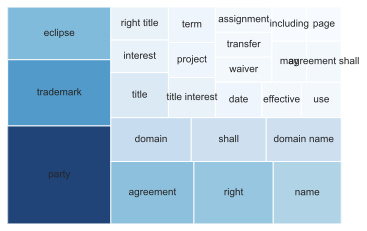

In [108]:
vector_treemap_plotter(cleaned_text, "Top 25 Words in Contract")


### Initial EDA Explanation

Thanks to pdf miner, we were able to convert our single pdf file into a gigantic string. As is expected, however, that conversion wasn't perfect - there were lots of unwanted characters, spaces, quotation marks etc. These had to be cleaned out and processed using `WordVectorizer` in order to get our bag of words that we could bring out into intial visualizations. 

Our initial EDA of this sample contract tells us that the top few words relate to "party", "trademark", "eclipse" and "agreement". 

"Party" and "agreement" aren't very special in a contract as they simply refer to the contract itself and the people who are the parties to it. However, drawing from my own subject expertise in law, the following words have special legal meanings:

**Trademark**: The second highest word count at 29 counts indicates that the agreement has to do with a trademark agreement. In a trademark licence agreement, the proprietor (Licensor) of a registered trademark gives authorization to another company (Licensee) to manufacture and distribute products under this trademark: https://www.globalnegotiator.com/international-trade/dictionary/trademark-license-agreement/#:~:text=Trade%20Tradem%20Tradeo-,Trademark%20license%20agreement,distribute%20products%20under%20this%20trademark.

**Domain Name** and **Eclipse** : That trademark agreement centers around the company's domain name "Eclipse".

**Title Interest**: This refers to the title and interest a.k.a the legal rights to use the "Domain Name", which is being assigned.

### What This Means for Modelling
The intrinsically technical nature of contracts makes it easy to bring out keywords, which in turn should ideally help us to boost the accuracy of topic modelling. We have only run this clean on sample contract, however.

Although I have a corpus of ~1000+ contracts at about nearly **800MB**, I haven't yet figured out how to write a for loop that does all of the above actions - including the pdf into dataframe row conversion - into one gigantic dataframe for the entire corpus. That will require further research, but for now we can see that the preliminary potential of topic modelling around contracts will work.

The somewhat large dataset may mean that I may be best served running the eventual giant clean and convert to the cloud or a hybrid of the cloud and on-premise computing. 